# RBA SOMP Forecasts

## Set-up

In [1]:
# system imports
import textwrap
import io
from pathlib import Path
from typing import Any, TypeAlias, cast

# analytic imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotting import clear_chart_dir, finalise_plot, set_chart_dir
import readabs as ra
from readabs import metacol as mc

In [2]:
# local imports
import common

In [3]:
# plotting constants
CHART_DIR = "./CHARTS/SOMP/"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
SHOW = False

## Collect and reorganise SOMP data

### Typing information

In [4]:
# Note: use NewType in the future when moved to Python 3.12

# dict holds data by report dates
# rows in df are subject domains columns are projection dates
DateSompType: TypeAlias = dict[str, pd.DataFrame]

# dict holds data by subject domain
# rows in df are projection dates, columns are report dates
DomainSompType: TypeAlias = dict[str, pd.DataFrame]

### Get raw SOMP tables

In [5]:
# Note: inclusive search terms:
START_YEAR = 2019
STOP_YEAR = 2024  # - this will need updating from year to year

In [6]:
def data_cleaning(frame: pd.DataFrame) -> pd.DataFrame:
    """Preliminary data cleaning for the raw SOMP
    data captured from the RBA website."""

    for col in frame.columns:

        # convert text fractions to decimals
        frame[col] = (
            frame[col]
            .astype(str)
            .str.replace("¼", ".25")
            .str.replace("½", ".5")
            .str.replace("¾", ".75")
            .str.replace("−", "-")
        )

        # make to NaN all non-numeric data
        frame[col] = pd.to_numeric(frame[col], errors="coerce")

    # delete all-NaN rows - Needed for Feb 24 report
    frame = frame = frame.dropna(how="all", axis="index")

    # remove odd footnotes from index introduced in Feb 2024
    # and standardize the case used in the index
    # (because of case mismatch before and after Feb 2024)
    frame.index = frame.index.str.replace(r"\([a-z]\)$", "", regex=True).str.title()

    return frame

In [7]:
def collect_somp_data() -> DateSompType:
    """Collect raw SOMP data, as presented in these SOMP
    reports. Returns one table for each report in a dict."""

    cache_dir = "./RBA_SOMP_CACHE"
    cache = Path(cache_dir)
    cache.mkdir(parents=True, exist_ok=True)
    q_start = {"feb": 1, "may": 2, "aug": 3, "nov": 4}

    pool: DateSompType = {}
    for year in range(START_YEAR, STOP_YEAR + 1):
        for qtr, q_number in q_start.items():

            # get URL
            url = (
                (
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/forecasts.html"
                )
                if year < 2024
                else (
                    # Change of RBA data location in Feb 2024 ...
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/outlook.html"
                )
            )

            # get the HTML text found at URL
            try:
                file = common.get_file(url, cache)
            except common.HttpError:
                print(f"Did not get: {year}-{qtr}")
                continue

            # get and clean relevant table from the HTML
            frame_list = pd.read_html(cast(str, io.BytesIO(file)), index_col=0)
            relevant_table = 0
            frame = data_cleaning(frame_list[relevant_table])

            # save the table into a dict
            index = f"{year}-Q{q_number}"
            pool[index] = frame

    return pool


raw_somp = collect_somp_data()

Did not get: 2024-aug
Did not get: 2024-nov


### Reorganise SOMP data

In [8]:
def reorganise_somp(inputs: dict[str, pd.DataFrame]) -> DomainSompType:
    """Reorganise the SOMP data
    from tables by date to tables by domain."""

    ue = "Unemployment Rate"
    pool: DomainSompType = {}
    for index, frame in inputs.items():
        for item in frame.index:
            if item[0] == "(":
                continue  # ignore footnotes
            row = frame.loc[item]
            row.name = index
            item_adj = ue if ue in item else item
            if item_adj not in pool:
                pool[item_adj] = pd.DataFrame(row)
            else:
                pool[item_adj] = pd.concat([pool[item_adj], pd.DataFrame(row)], axis=1)

    for table in pool.values():
        table.columns = pd.PeriodIndex(table.columns, freq="Q-NOV")
        table.index = pd.PeriodIndex(table.index, freq="Q-DEC")

    return pool


somp: DomainSompType = reorganise_somp(raw_somp)
textwrap.wrap(", ".join(somp.keys()), width=100)

['Gross Domestic Product, Household Consumption, Dwelling Investment, Business Investment, Public',
 'Demand, Gross National Expenditure, Imports, Exports, Real Household Disposable Income, Terms Of',
 'Trade, Major Trading Partner (Export-Weighted) Gdp, Unemployment Rate, Employment, Wage Price Index,',
 'Nominal (Non-Farm) Average Earnings Per Hour, Trimmed Mean Inflation, Consumer Price Index, Hours-',
 'Based Underutilisation Rate (Quarterly, %), Nominal Average Earnings Per Hour (Non-Farm), Cash Rate',
 '(%), Trade-Weighted Index (Index), Brent Crude Oil Price (Us$/Bbl), Estimated Resident Population,',
 'Labour Productivity, Household Savings Rate (%), Real Wage Price Index, Real Average Earnings Per',
 'Hour (Non-Farm)']

### Get key ABS data

In [9]:
def get_data() -> tuple[dict[str, pd.Series], pd.DataFrame]:
    """Get a dictionary of data items from the ABS."""

    gdp_cat, gdp_sas = "5206.0", "5206024_Selected_Analytical_Series"
    gdp_kags = "5206001_Key_Aggregates"
    gdp_hhc = "5206008_Household_Final_Consumption_Expenditure"
    gdp_exp = "5206002_Expenditure_Volume_Measures"
    gdp_ipd = "5206005_Expenditure_Implicit_Price_Deflators"
    gdp_hhi = "5206020_Household_Income"
    cpi_cat, cpi_seo = "6401.0", "640106"
    wpi_cat, wpi_seo = "6345.0", "634501"
    lfs_cat, lfs_seo = "6202.0", "6202001"
    la_cat, la_seo = "6150.0.55.003", "6150055003DO001"

    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"]
        "A2325846C": [cpi_cat, cpi_seo, "CPI Index Orig"],
        "A3604506F": [cpi_cat, cpi_seo, "CPI Index SA"],
        "A3604509L": [cpi_cat, cpi_seo, "CPI Index TM SA"],
        "A2302460K": [gdp_cat, gdp_kags, "GDP per capita CVM Orig"],  # for population
        "A2302459A": [gdp_cat, gdp_kags, "GDP CVM Orig"],  # for population
        "A2304404C": [gdp_cat, gdp_kags, "GDP per capita CVM SA"],
        "A2304402X": [gdp_cat, gdp_kags, "GDP CVM SA"],
        "A2323382F": [gdp_cat, gdp_kags, "Household savings ratio SA"],
        "A2303280V": [gdp_cat, gdp_hhc, "Household consumption CVM SA"],
        "A2304098T": [gdp_cat, gdp_exp, "Dwelling Investment CVM SA"],
        "A2304113C": [gdp_cat, gdp_exp, "GNE CVM SA"],
        "A2304114F": [gdp_cat, gdp_exp, "Exports CVM SA"],
        "A2304115J": [gdp_cat, gdp_exp, "Imports CVM SA"],
        "A2713849C": [wpi_cat, wpi_seo, "WPI Index SA"],
        "A84423043C": [lfs_cat, lfs_seo, "Thousand Employed SA"],
        "A84423050A": [lfs_cat, lfs_seo, "Unemployment Rate SA"],
        "A2303940R": [gdp_cat, gdp_ipd, "HHIPD Index CVM SA"],
        "A2303727C": [gdp_cat, gdp_ipd, "GNEIPD Index CVM SA"],
        "A2303730T": [gdp_cat, gdp_ipd, "GDPIPD Index CVM SA"],
        "A2302939L": [gdp_cat, gdp_hhi, "Gross Disposable Income CP SA"],
        "A85389483J": [la_cat, la_seo, "Hours worked all jobs SA"],
    }

    data, meta, cat = {}, {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        data[title] = d[series_id]
        meta[title] = m.loc[series_id]
        cat[title] = category_id

    data["Million population"] = data["GDP CVM Orig"] / data["GDP per capita CVM Orig"]
    cat["Million population"] = gdp_cat

    # See table H from the RBA Statistical Tables: 'Real household disposable income' is
    # household disposable income after the deduction of interest payments, deflated by
    # the implicit price deflator for household consumption expenditure; includes income
    # from unincorporated enterprises.
    data["HHIPD Index rebase"] = (
        data["HHIPD Index CVM SA"] / data["HHIPD Index CVM SA"].iloc[-1]
    )
    data["Real Household Disposable Income"] = (
        data["Gross Disposable Income CP SA"] / data["HHIPD Index rebase"]
    )
    cat["Real Household Disposable Income"] = gdp_cat

    data["Labour Productivity"] = (data["GDP CVM SA"] * 1_000) / data[
        "Hours worked all jobs SA"
    ]
    cat["Labour Productivity"] = f"{gdp_cat} {la_cat}"

    return data, pd.DataFrame(meta).T, cat


abs_data, abs_meta, abs_cat = get_data()
# abs_meta

## Plotting

### ABS/SOMP pairs

In [10]:
def plot_somp(
    ax: mpl.axes.Axes,
    somp_df: pd.DataFrame,
    last_n: int = 0,
) -> None:
    """Add the quarterly SOMP forecasts to a plot."""

    df = somp_df.copy()  # non destructive
    df = df[df.columns[-last_n:]] if last_n else df

    n_colours = len(df.columns)
    gradient = np.linspace(0, 1, n_colours)
    cmap = cmap = plt.get_cmap("viridis")
    colors = (
        cmap(gradient)
        if last_n == 0 or last_n > 2
        else ("cornflowerblue", "darkorange")
    )
    xy = set()
    last = df.columns[-1]

    for col, color in zip(df.columns, colors):
        s = df[col].astype(float).dropna()  # kludge
        if s.notna().sum() == 0 or s.index[0].year < START_YEAR:
            continue
        color = "darkred" if col == last else color
        s.plot(ax=ax, lw=1, c=color, ls="--", label=str(col)[2:])
        x, y = s.index[-1], s.iloc[-1]
        # let's minimise over-plotting of text
        va = "bottom" if (x, y) not in xy else "top"
        ax.text(x=x, y=y, s=str(col)[2:], fontsize=6, va=va)
        xy.add((x, y))

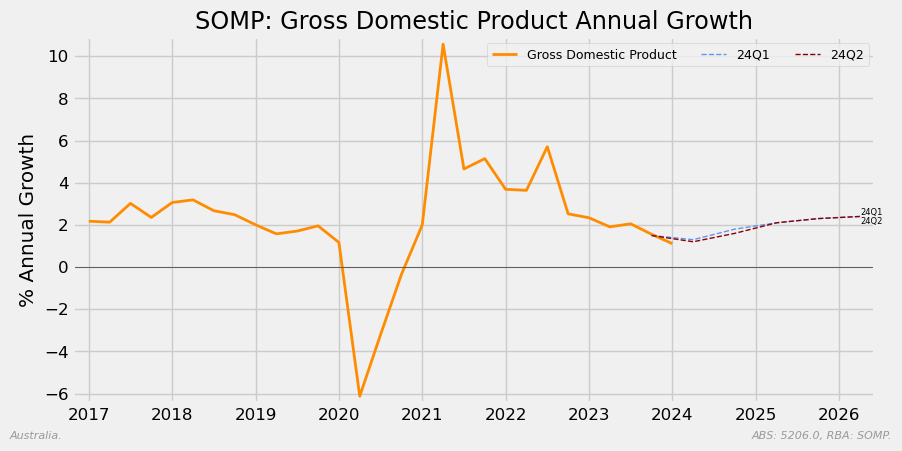

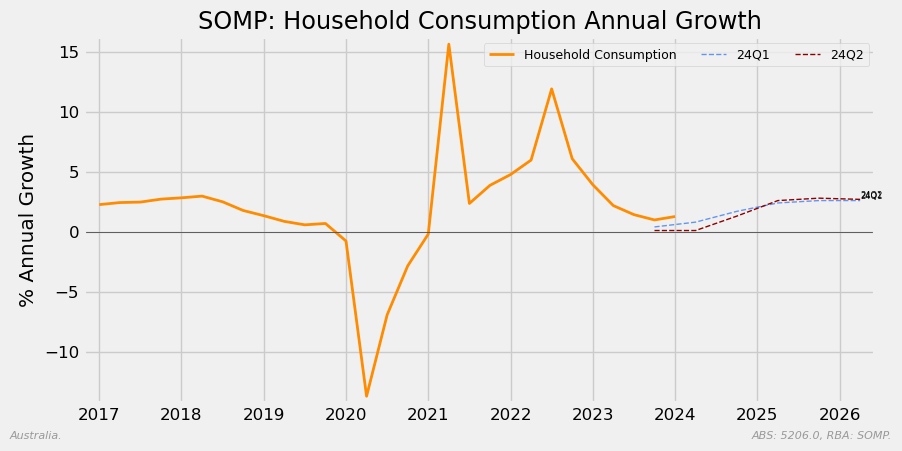

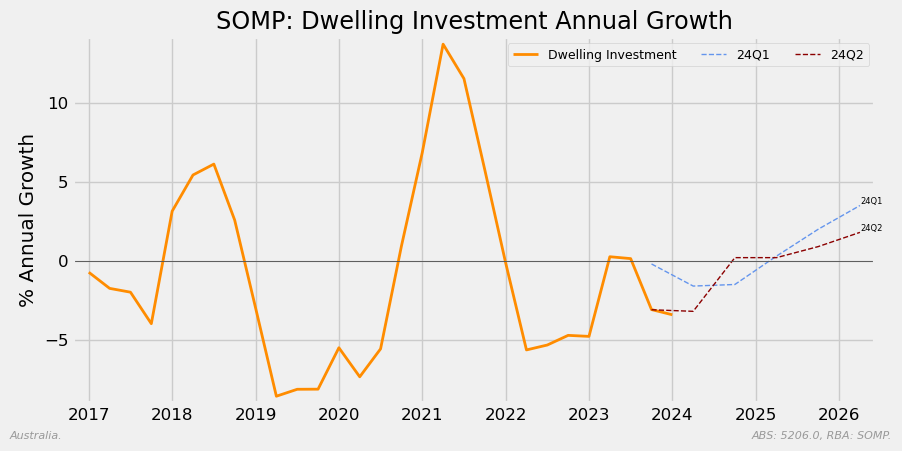

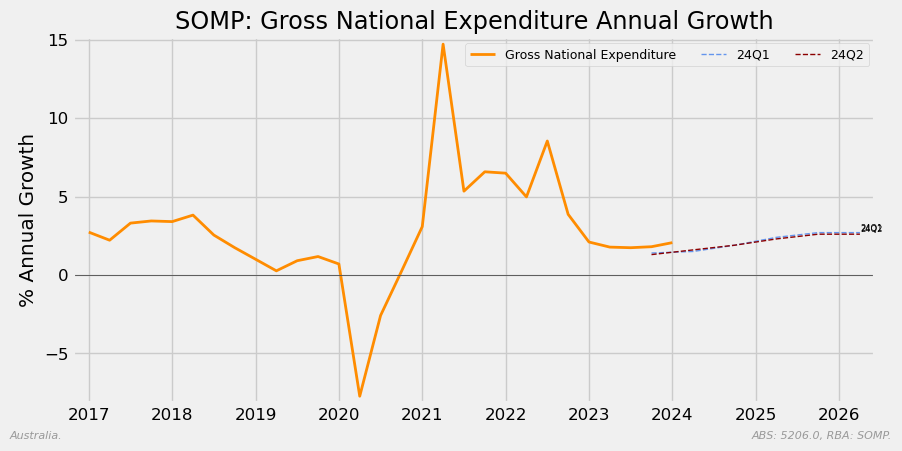

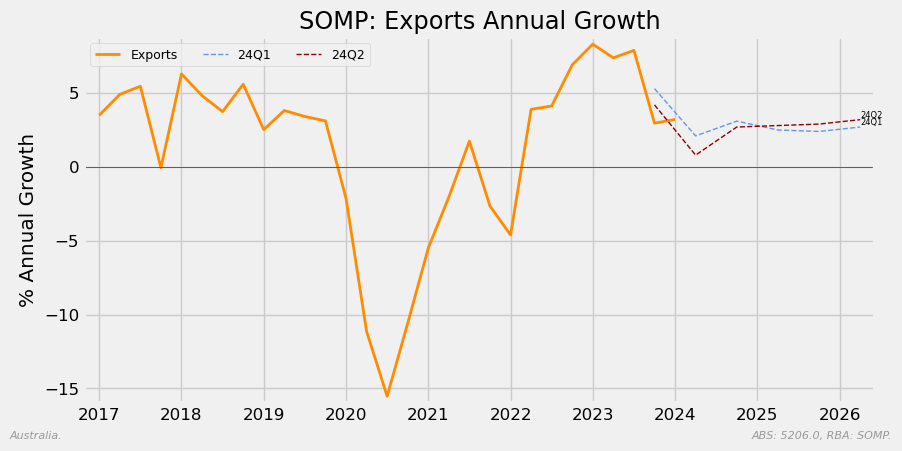

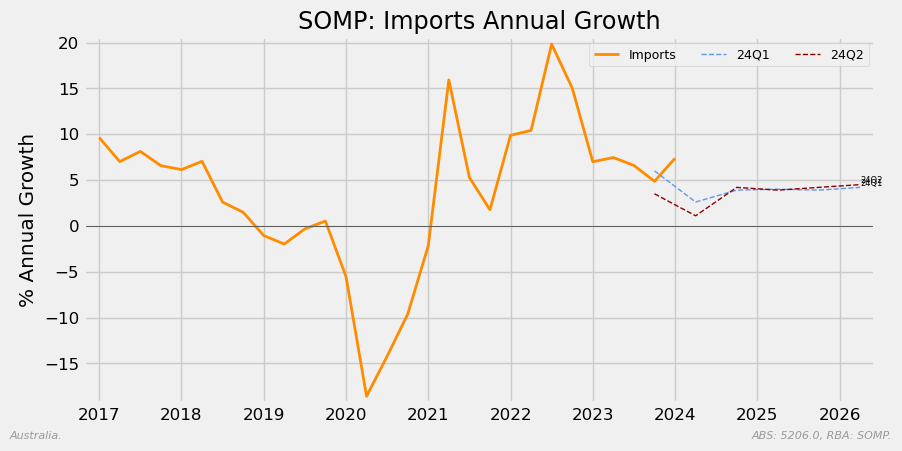

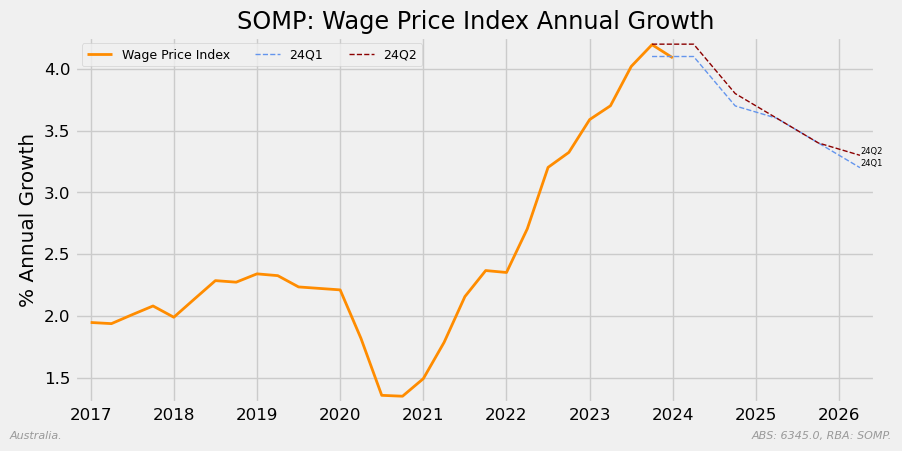

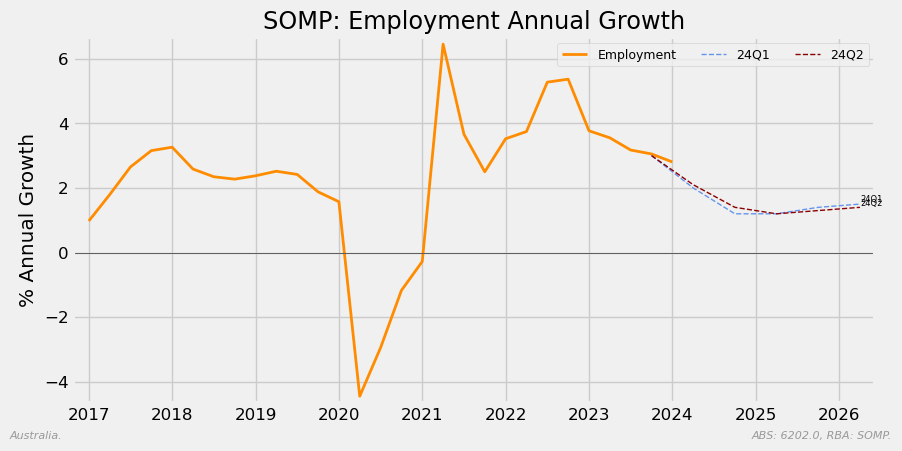

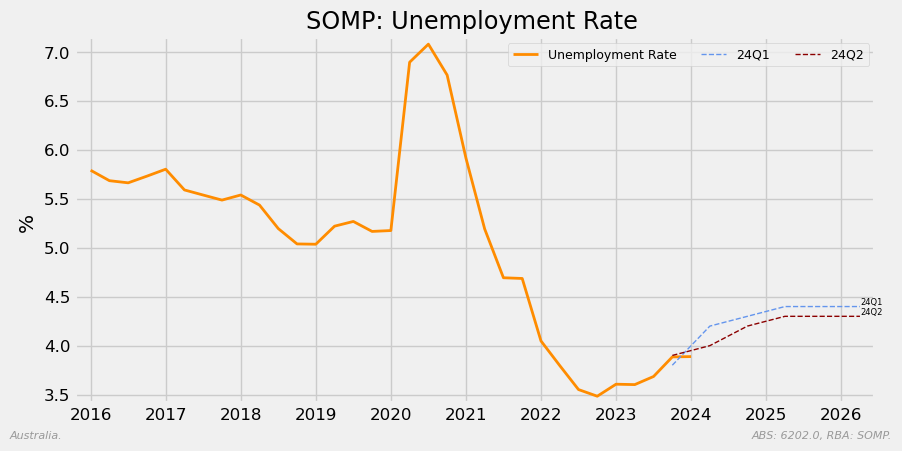

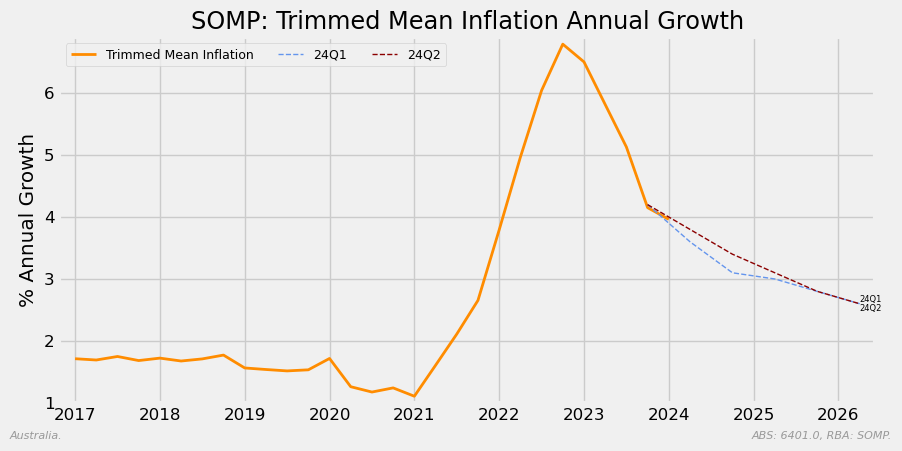

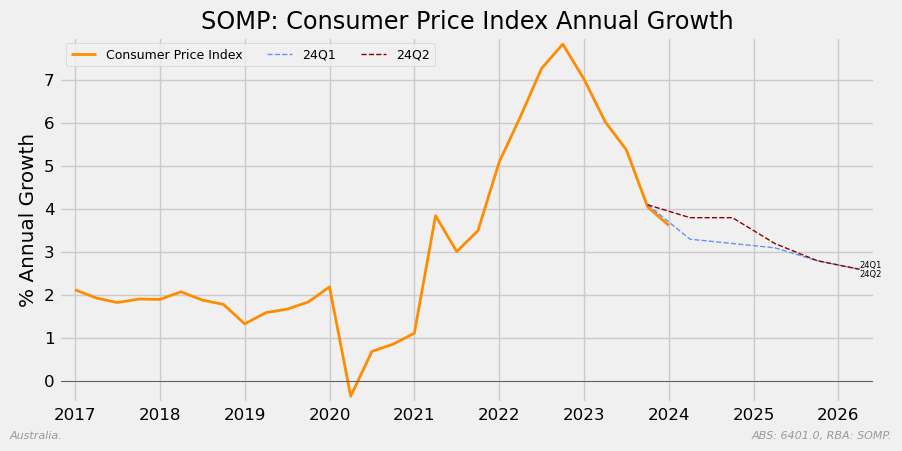

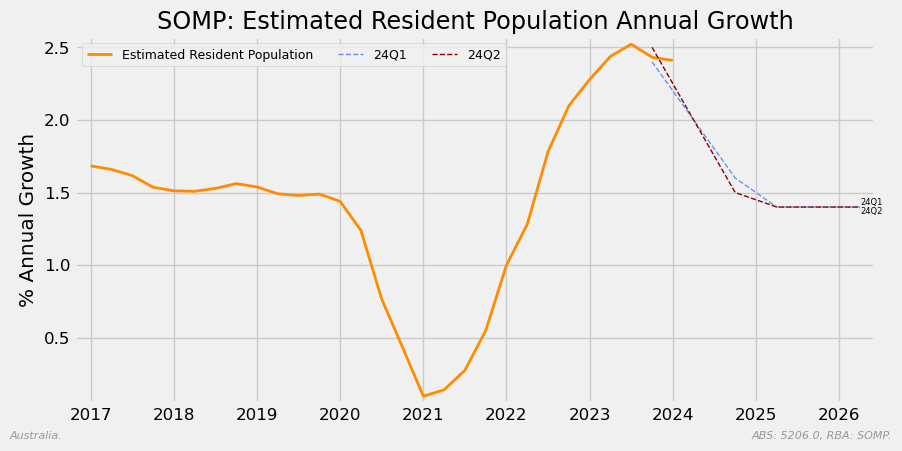

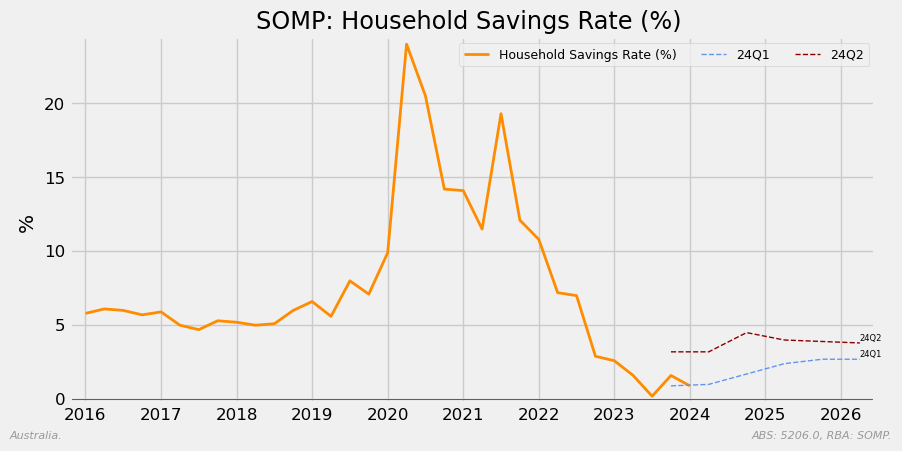

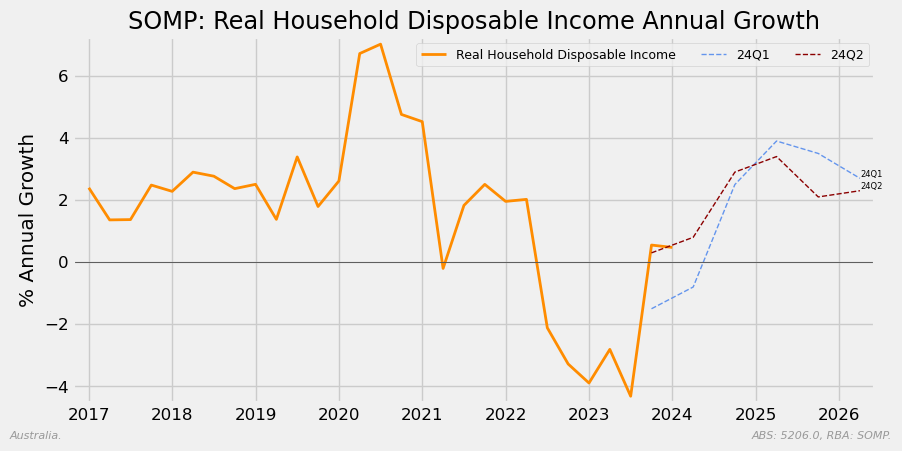

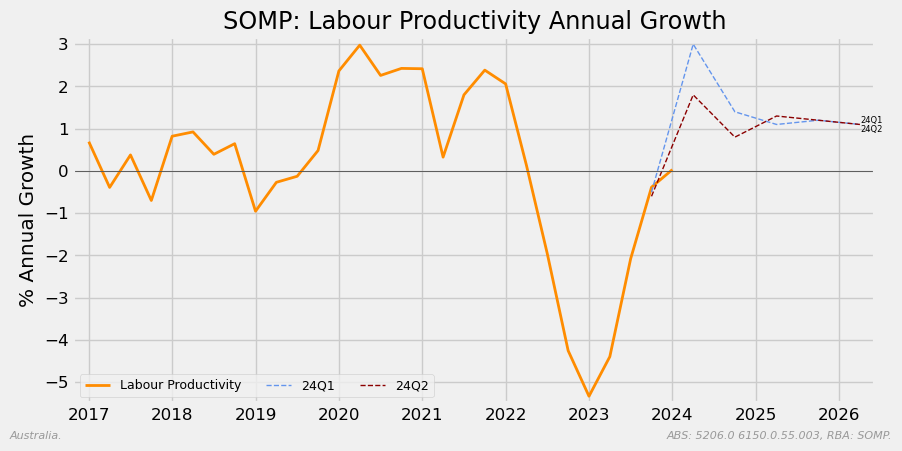

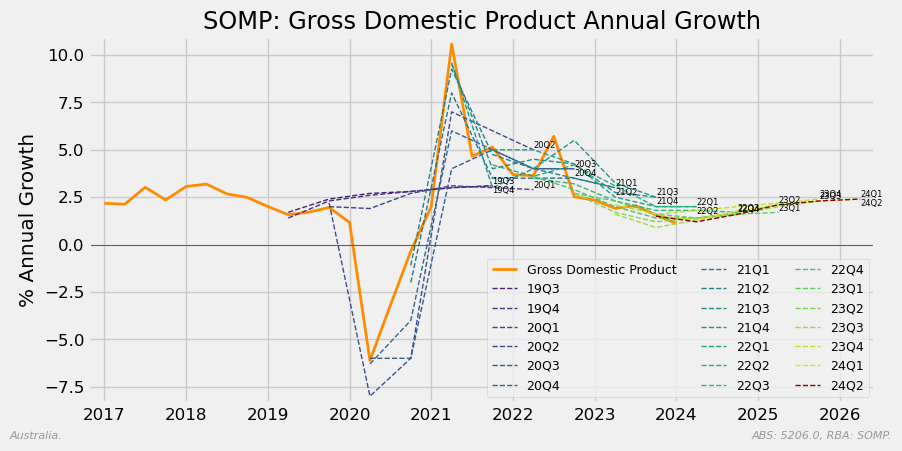

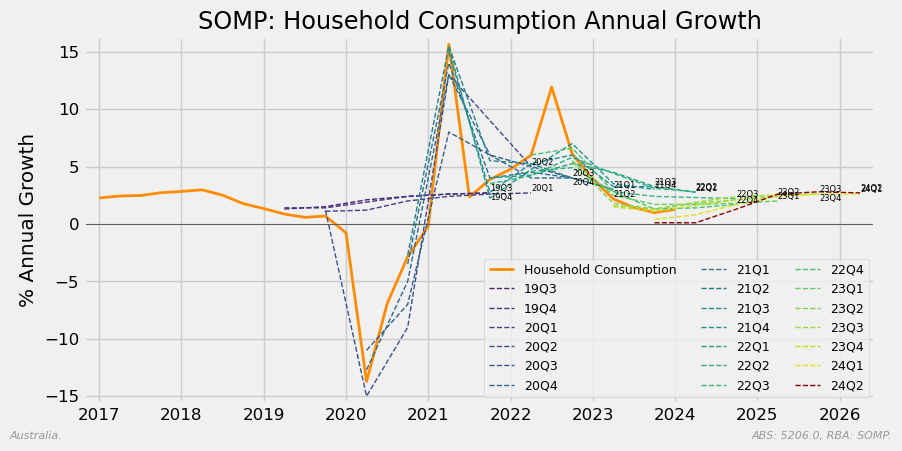

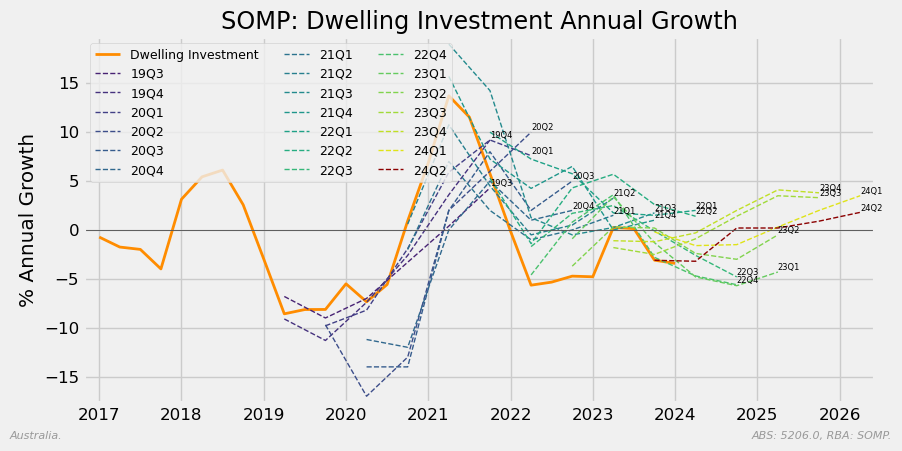

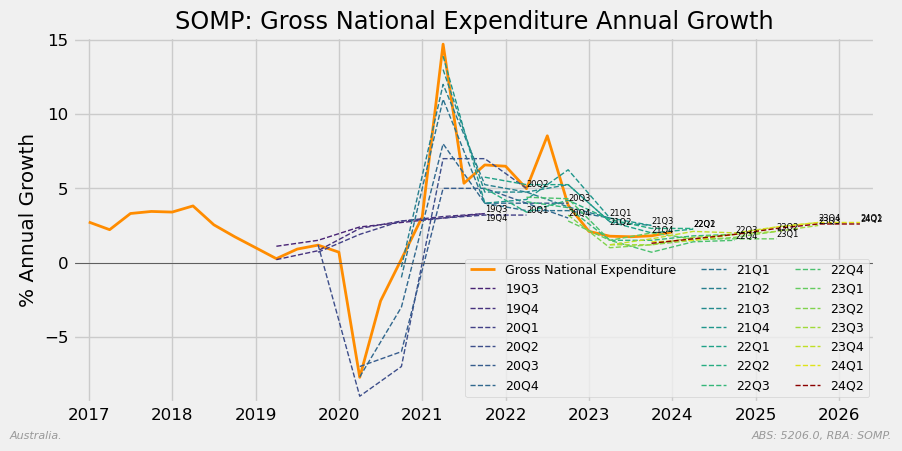

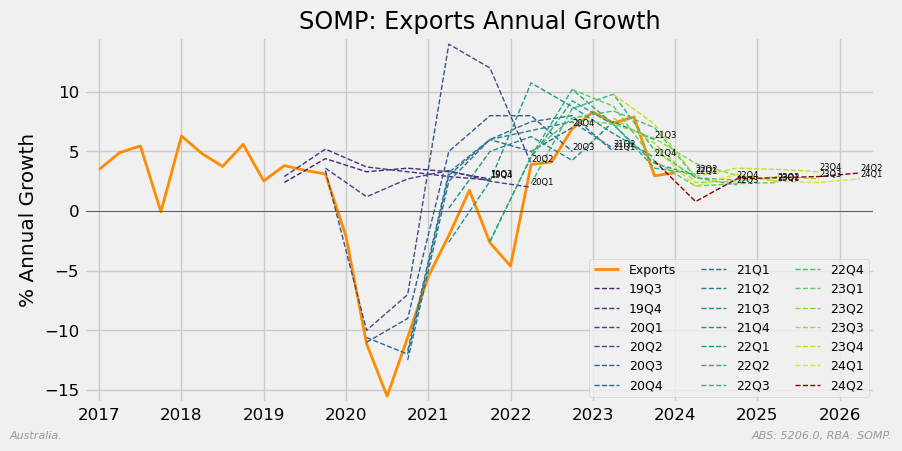

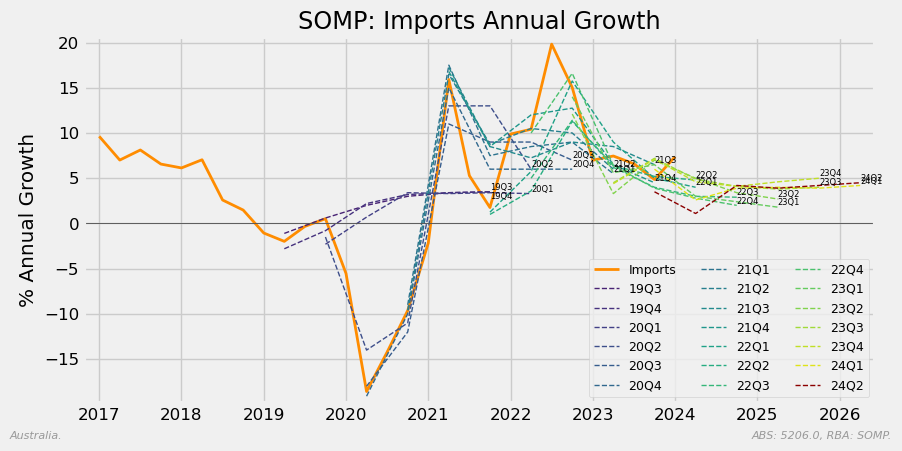

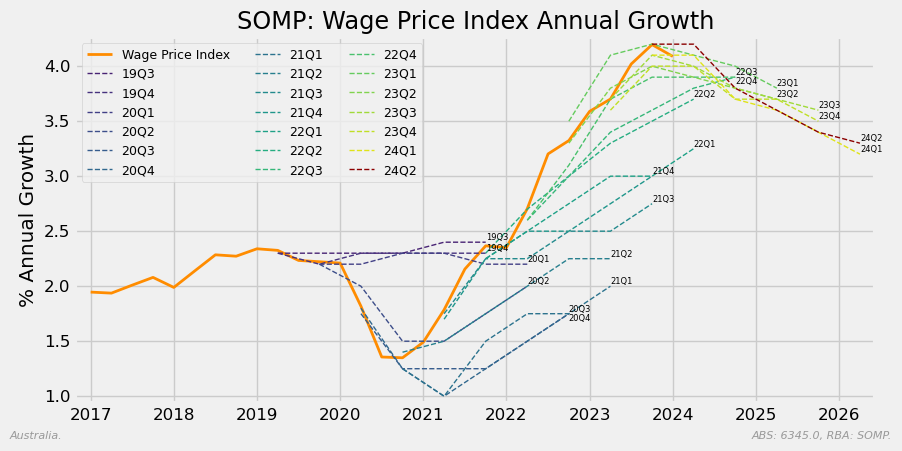

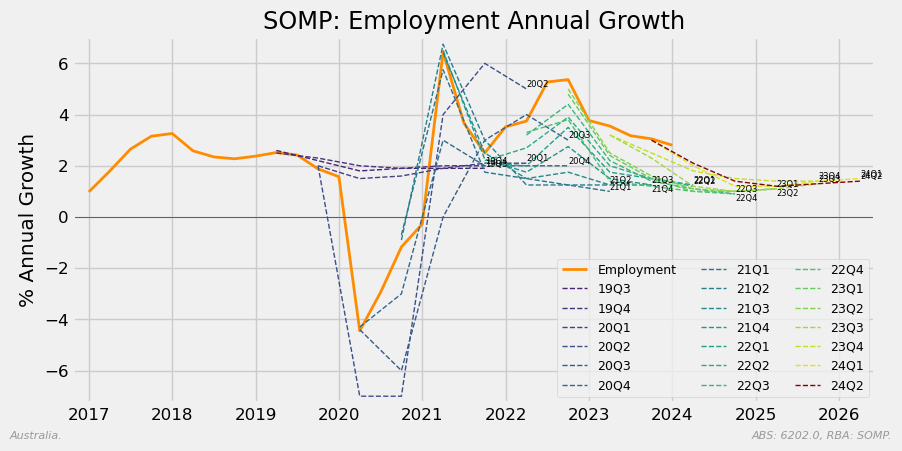

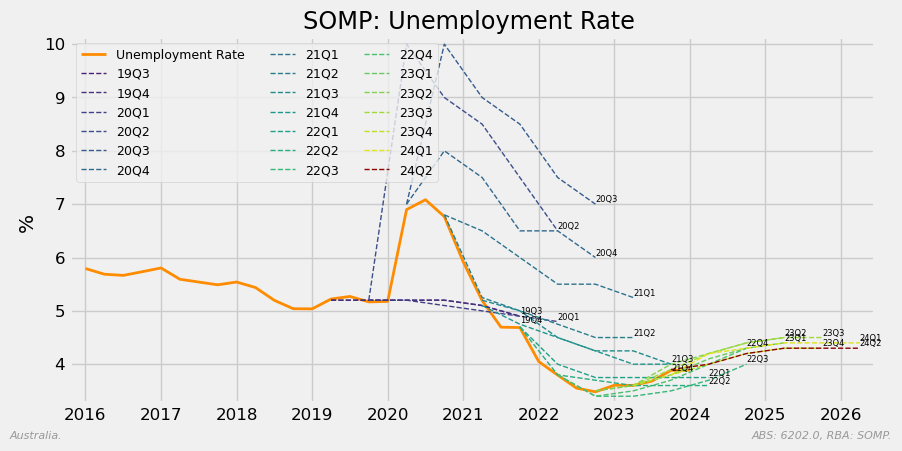

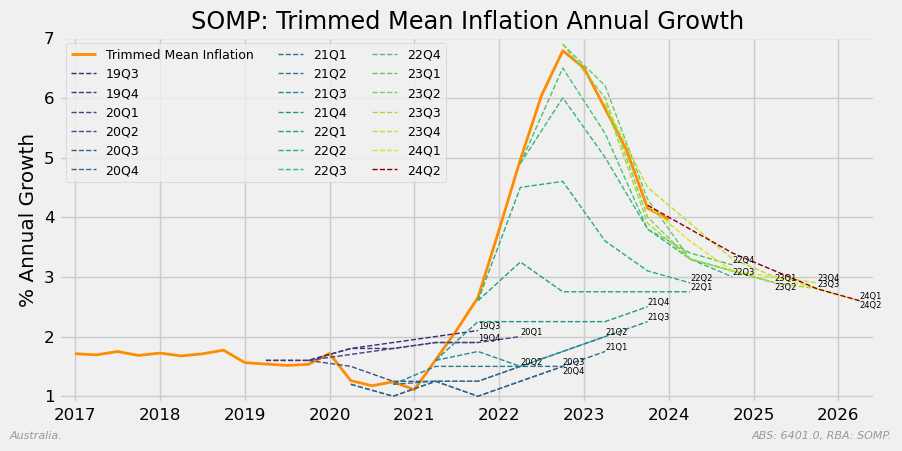

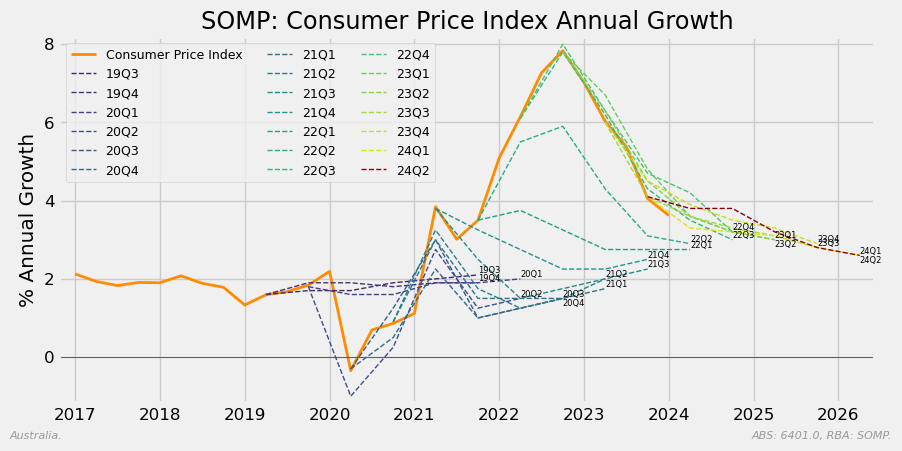

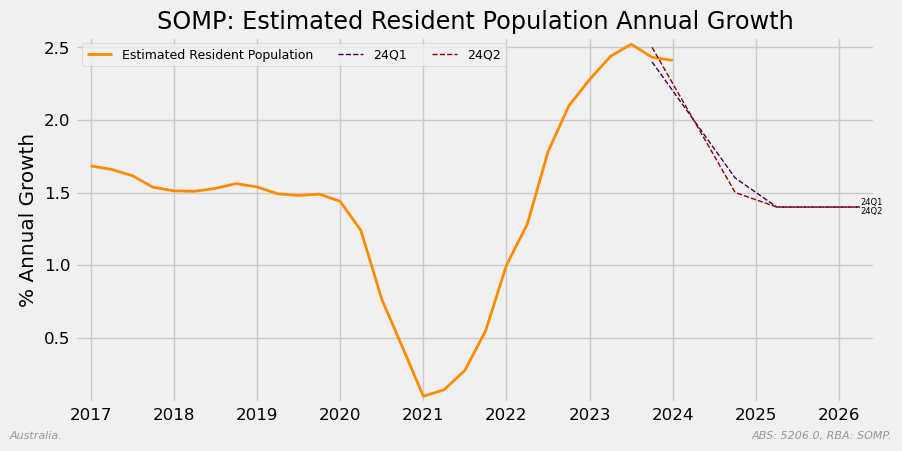

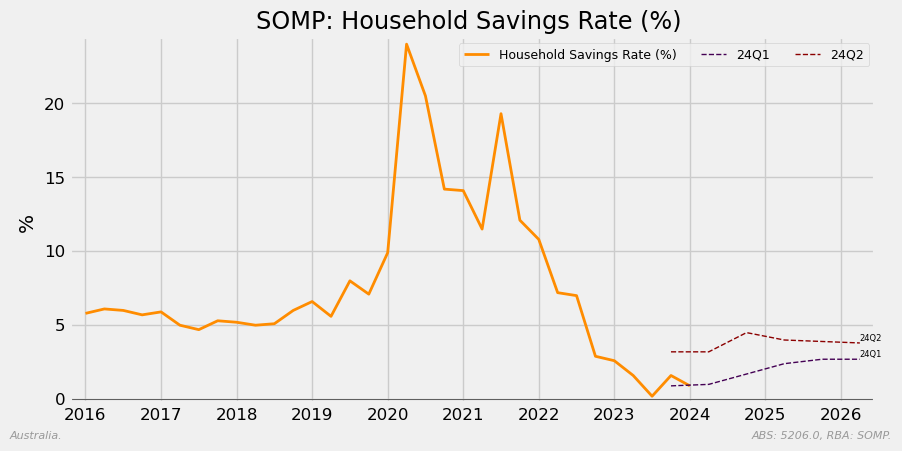

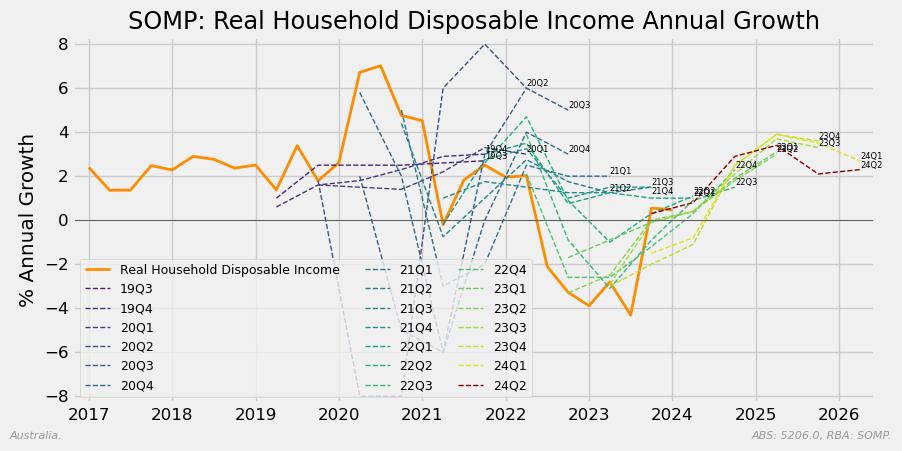

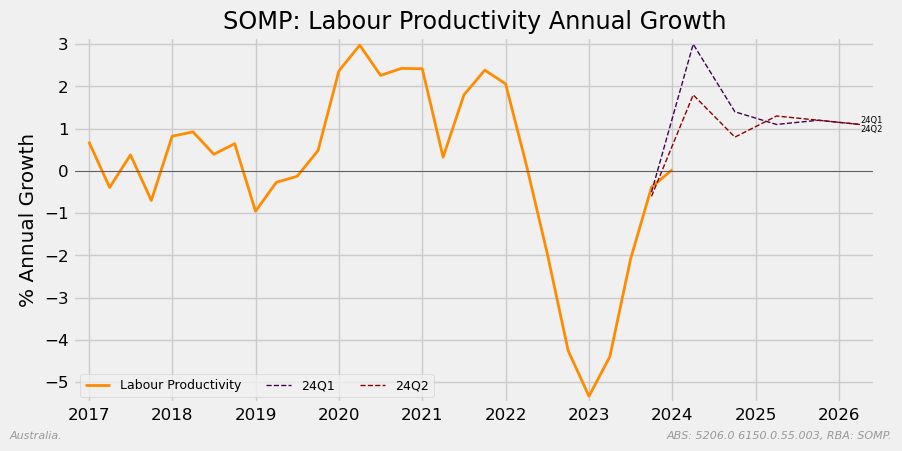

In [11]:
def plot_somp_abs_pairs(start=f"{START_YEAR-3}-01-01", last_n=2) -> None:
    """Plot SOMP forecasts against ABS data."""

    # identify the pairs of SOMP and ABS data
    somp_abs_pairs = [
        ("Gross Domestic Product", "GDP CVM SA"),
        ("Household Consumption", "Household consumption CVM SA"),
        ("Dwelling Investment", "Dwelling Investment CVM SA"),
        ("Gross National Expenditure", "GNE CVM SA"),
        ("Exports", "Exports CVM SA"),
        ("Imports", "Imports CVM SA"),
        ("Wage Price Index", "WPI Index SA"),
        ("Employment", "Thousand Employed SA"),
        ("Unemployment Rate", "Unemployment Rate SA"),
        ("Trimmed Mean Inflation", "CPI Index TM SA"),
        ("Consumer Price Index", "CPI Index Orig"),
        ("Estimated Resident Population", "Million population"),
        ("Household Savings Rate (%)", "Household savings ratio SA"),
        ("Real Household Disposable Income", "Real Household Disposable Income"),
        ("Labour Productivity", "Labour Productivity"),
    ]

    # plot the data
    exceptions = ["Unemployment Rate", "Household Savings Rate (%)"]
    for s, a in somp_abs_pairs:
        series = abs_data[a].loc[start:]
        freq = series.index.freqstr[0]
        if freq == "M":
            series = ra.monthly_to_qtly(series)
        if s not in exceptions:
            growth = series.pct_change(periods=4).dropna() * 100.0
            title = "Annual Growth"
        else:
            growth = series
            title = ""
        growth.name = s
        ax = growth.plot(lw=2, color="darkorange")
        plot_somp(ax, somp[s], last_n=last_n)
        finalise_plot(
            ax,
            title=f"SOMP: {s} {title}",
            ylabel=f"% {title}",
            legend={"loc": "best", "fontsize": 9, "ncol": 3},
            lfooter="Australia. ",
            rfooter=f"ABS: {abs_cat[a]}, RBA: SOMP.",
            tag=f"{last_n}",
            y0=True,
            show=True,
        )


for n in 2, 0:
    plot_somp_abs_pairs(last_n=n)

### Cash rate

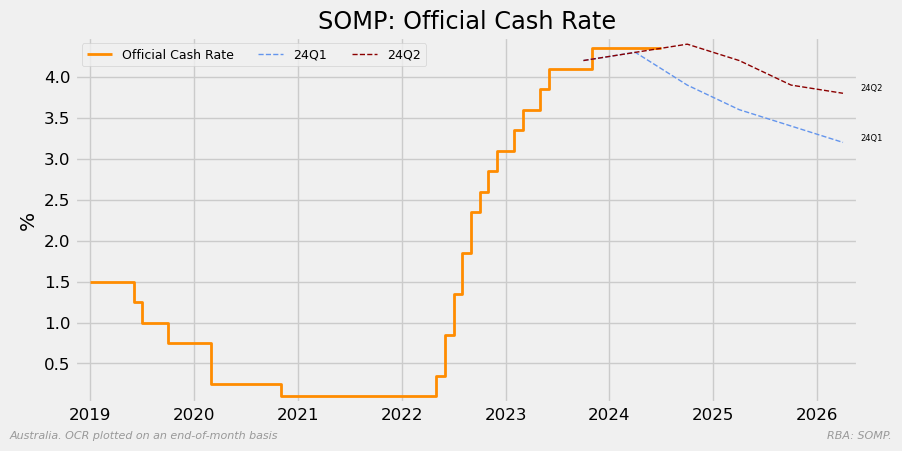

In [17]:
def plot_cr(somp_data: DomainSompType) -> None:
    """Produce a cash rate chart."""

    # plot the official cash rate history
    ocr_rba = ra.read_rba_ocr()
    ax = ocr_rba[ocr_rba.index.year >= START_YEAR].plot(lw=2, color="darkorange", drawstyle="steps-post")
    plot_somp(ax, somp["Cash Rate (%)"], last_n=2)
    finalise_plot(
        ax,
        title=f"SOMP: Official Cash Rate",
        ylabel="%",
        legend={"loc": "best", "fontsize": 9, "ncol": 3},
        lfooter="Australia. OCR plotted on an end-of-month basis",
        rfooter="RBA: SOMP.",
        y0=True,
        show=True,
    )


plot_cr(somp)

## Finished

In [ ]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Jul 17 2024 15:23:02

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 1.26.4
readabs   : 0.0.12a0

Watermark: 2.4.3



In [ ]:
print("Finished.")

Finished.
